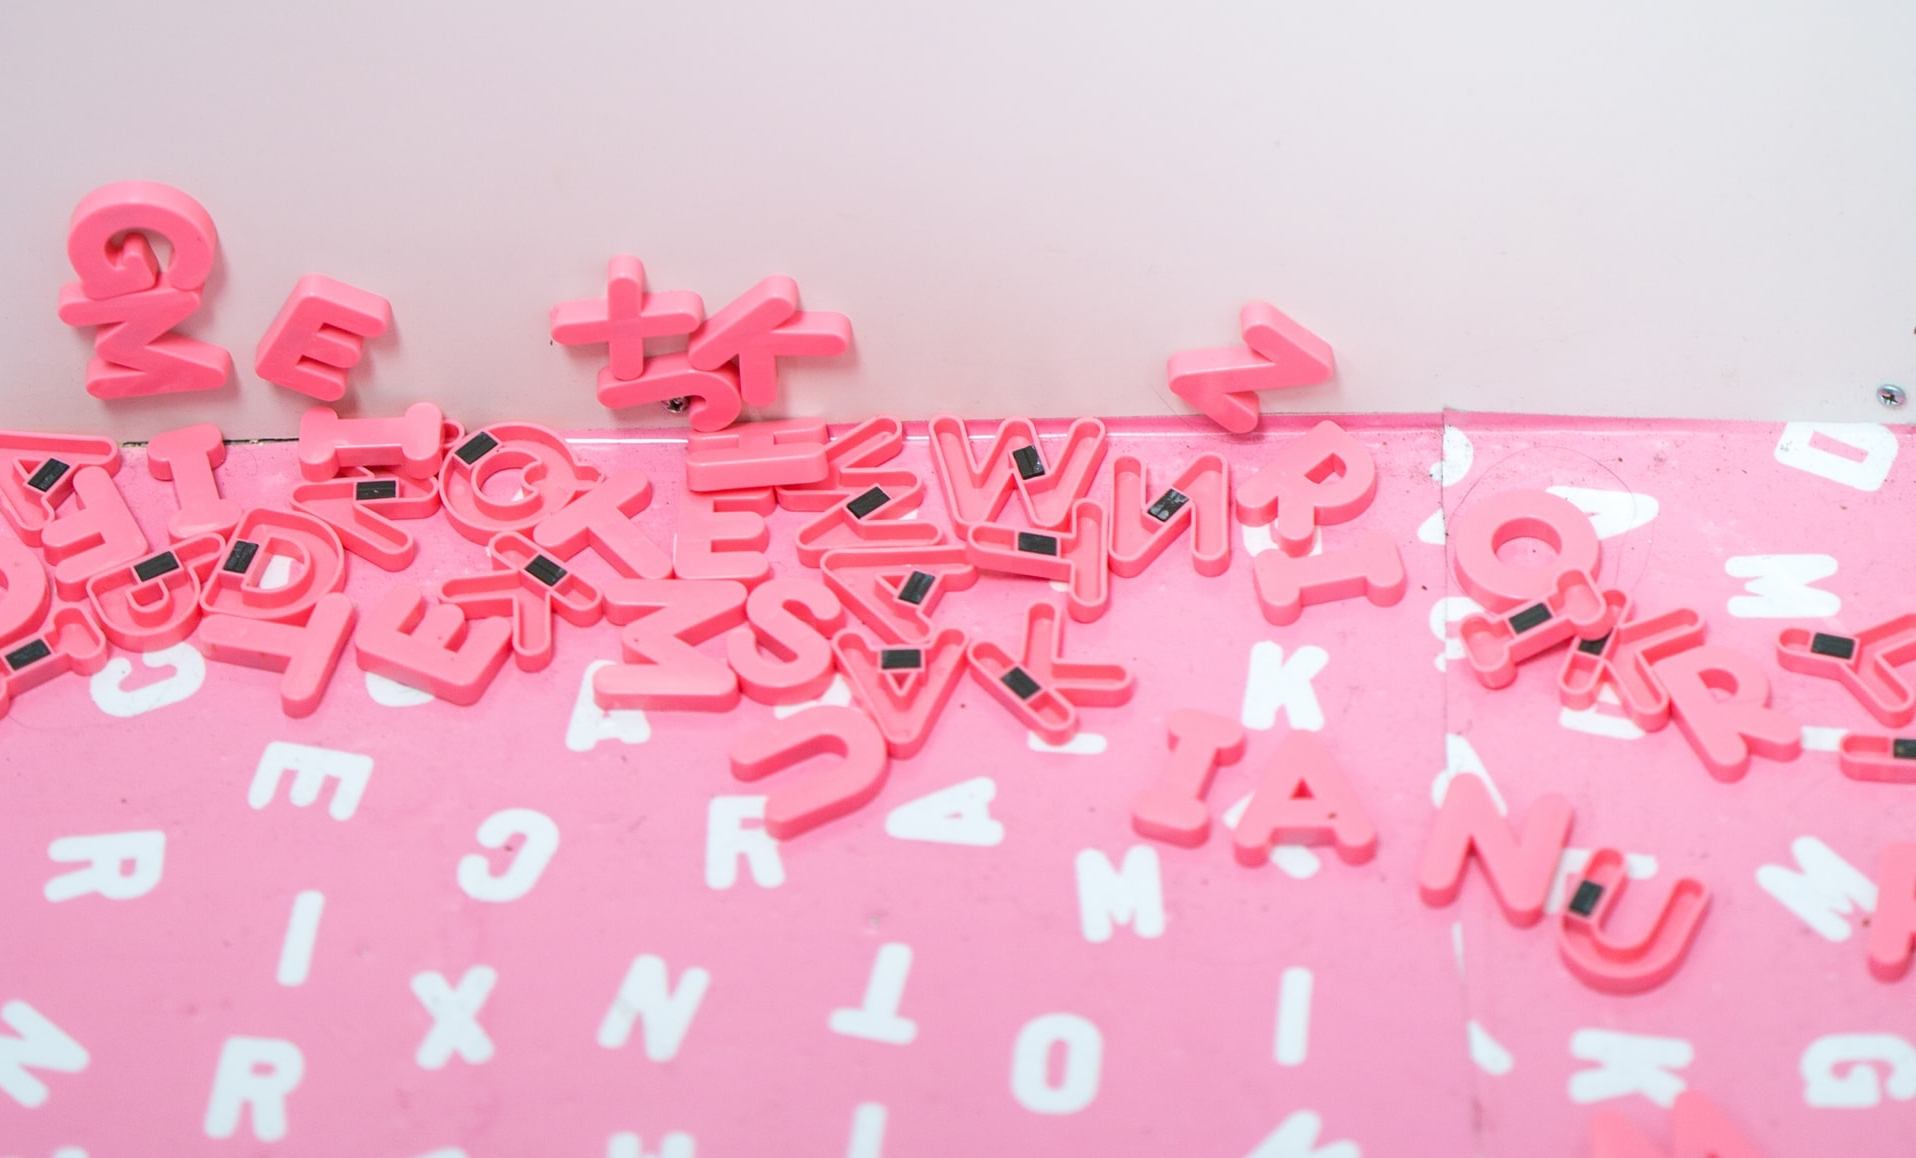

*Credits*: <span>Photo by <a href="https://unsplash.com/@ninjason?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Jason Leung</a> on <a href="https://unsplash.com/s/photos/language?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText">Unsplash</a></span>

The place of language in our lives is hard to overestimate. It helps us to convey meaning and not rarely serves as a means of persuasion.

Have you ever noticed that words may be a good indicator of the cost? "Exclusive", "brand-new", "luxurious" and similar terms signal that the service or the product described will be rather expensive. 

Well, if it's in fact so, can we create a program that would predict prices by product names? Sure, we can!

Today we'll use NLP to understand whether there are particular wordings that indicate high end prices for Airbnb places in New Yourk City.


[Preprocessing](#prep)

[Most frequent words](#freq_words)

[Most frequent bigrams](#freq_bigrams)

[Most frequent trigrams](#freq_trigrams)

[But what about a price?](#price)

[Most frequent wordings for expensive places](#top_costly_words)

[ML model](#model)

[Interpreting ML predictions](#interpret)

[Wrapping up](#wrapping_up)


First, let's load the data and take a quick look at it.

In [21]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

from PIL import Image
from wordcloud import WordCloud

import spacy
import nltk
from nltk.util import ngrams

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, classification_report, mean_absolute_error, r2_score
from imblearn.over_sampling import RandomOverSampler, SMOTE

import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# DATA FROM: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

data = pd.read_csv('AB_NYC_2019.csv')
data.shape

(48895, 16)

In [3]:
data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

Let's look at the columns of our data.

* id - Listing ID
* name - Listing Title
* host_id - ID of Host
* host_name - Name of Host
* neighbourhood_group - Borough that contains listing
* neighbourhood - Name of neighbourhood that listing is in
* latitude - latitude of listing
* longitude - longitude of listing
* room_type - Type of public space that is being offered
* price - price per night, USD
* minimum_nights - minimum number of nights required to book listing
* number_of_reviews - total number of reviews that listing has accumulated
* last_review - date in which listing was last rented
* reviews_per_month - total number of reviews divided by the number of months the listing is active
* calculated_host_listings_count - amount of listing per host**
* availability_365 - number of days per year the listing is active

As we are interested in textual descriptions of appartments, we need to preprocess data in `name` column for further use.

## <a id='prep'></a> <font color='orange'> Preprocessing
### <font color='orange'> 1. Check if there are missing values. If so, swap it with an empty string.


In [4]:
# Looks like there are 16 objects with no description.
data[data['name'].isnull()]

id name   host_id host_name neighbourhood_group  \
2854    1615764  NaN   6676776     Peter           Manhattan   
3703    2232600  NaN  11395220      Anna           Manhattan   
5775    4209595  NaN  20700823     Jesse           Manhattan   
5975    4370230  NaN  22686810   Michaël           Manhattan   
6269    4581788  NaN  21600904     Lucie            Brooklyn   
6567    4756856  NaN   1832442  Carolina            Brooklyn   
6605    4774658  NaN  24625694      Josh           Manhattan   
8841    6782407  NaN  31147528  Huei-Yin            Brooklyn   
11963   9325951  NaN  33377685  Jonathan           Manhattan   
12824   9787590  NaN  50448556    Miguel           Manhattan   
13059   9885866  NaN  37306329  Juliette           Manhattan   
13401  10052289  NaN  49522403   Vanessa            Brooklyn   
15819  12797684  NaN  69715276       Yan           Manhattan   
16071  12988898  NaN  71552588    Andrea               Bronx   
18047  14135050  NaN  85288337      Jeff            Brooklyn   
28889  22275821  NaN  49662398  Kathleen            Brooklyn   

            neighbourhood  latitude  longitude        room_type  price  \
2854    Battery Park City  40.71239  -74.01620  Entire home/apt    400   
3703         East Village  40.73215  -73.98821  Entire home/apt    200   
5775    Greenwich Village  40.73473  -73.99244  Entire home/apt    225   
5975               Nolita  40.72046  -73.99550  Entire home/apt    215   
6269         Williamsburg  40.71370  -73.94378     Private room    150   
6567             Bushwick  40.70046  -73.92825     Private room     70   
6605   Washington Heights  40.85198  -73.93108     Private room     40   
8841         Williamsburg  40.71354  -73.93882     Private room     45   
11963      Hell's Kitchen  40.76436  -73.98573  Entire home/apt    190   
12824              Harlem  40.80316  -73.95189  Entire home/apt    300   
13059           Chinatown  40.71632  -73.99328     Private room     67   
13401         Brownsville  40.66409  -73.92314     Private room     50   
15819     Upper West Side  40.79843  -73.96404     Private room    100   
16071             Fordham  40.86032  -73.88493      Shared room    130   
18047  Bedford-Stuyvesant  40.69421  -73.93234     Private room     70   
28889            Bushwick  40.69546  -73.92741  Entire home/apt    110   

       minimum_nights  number_of_reviews last_review  reviews_per_month  \
2854             1000                  0         NaN                NaN   
3703                1                 28  2015-06-08               0.45   
5775                1                  1  2015-01-01               0.02   
5975                7                  5  2016-01-02               0.09   
6269                1                  0         NaN                NaN   
6567                1                  0         NaN                NaN   
6605                1                  0         NaN                NaN   
8841                1                  0         NaN                NaN   
11963               4                  1  2016-01-05               0.02   
12824               5                  0         NaN                NaN   
13059               4                  0         NaN                NaN   
13401               3                  3  2016-08-18               0.07   
15819               1                  0         NaN                NaN   
16071               1                  0         NaN                NaN   
18047               3                  0         NaN                NaN   
28889               4                  5  2018-08-13               0.27   

       calculated_host_listings_count  availability_365  
2854                                1               362  
3703                                1               341  
5775                                1                 0  
5975                                1                 0  
6269                                1                 0  
6567                                1    

In [5]:
# Fill NaN with an empty string and check missing values again
data['name'].fillna('', inplace=True)
data['name'].isnull().sum()

0

### <font color='orange'> 2. Remove punctuation, digits and special characters.

In [6]:
def remove_punct(line):
    return re.sub('[^A-Za-z]+', ' ', line).lower()

data['clean_name'] = data['name'].apply(remove_punct)

In [7]:
# Let's compare raw and cleaned texts.
data[['name', 'clean_name']]

name  \
0                     Clean & quiet apt home by the park   
1                                  Skylit Midtown Castle   
2                    THE VILLAGE OF HARLEM....NEW YORK !   
3                        Cozy Entire Floor of Brownstone   
4       Entire Apt: Spacious Studio/Loft by central park   
...                                                  ...   
48890    Charming one bedroom - newly renovated rowhouse   
48891      Affordable room in Bushwick/East Williamsburg   
48892            Sunny Studio at Historical Neighborhood   
48893               43rd St. Time Square-cozy single bed   
48894  Trendy duplex in the very heart of Hell's Kitchen   

                                              clean_name  
0                       clean quiet apt home by the park  
1                                  skylit midtown castle  
2                        the village of harlem new york   
3                        cozy entire floor of brownstone  
4        entire apt spacious studio loft by central park  
...                                                  ...  
48890      charming one bedroom newly renovated rowhouse  
48891      affordable room in bushwick east williamsburg  
48892            sunny studio at historical neighborhood  
48893                  rd st time square cozy single bed  
48894  trendy duplex in the very heart of hell s kitchen  

[48895 rows x 2 columns]

### <font color='orange'> 3. Get rid of stopwords, i.e. words conveying no meaning such as articles, conjunctions, etc. 

In [11]:
#!python -m spacy download en

In [10]:
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words

In [12]:
def tokenize_no_stopwords(line):
    tokens = nltk.tokenize.word_tokenize(line)
    tokens_no_stop = [w for w in tokens if w not in stopwords]
    return " ".join(tokens_no_stop)

In [13]:
data['final_name'] = data['clean_name'].apply(tokenize_no_stopwords)

In [14]:
# Well, looks about right
data[['clean_name', 'final_name']]

clean_name  \
0                       clean quiet apt home by the park   
1                                  skylit midtown castle   
2                        the village of harlem new york    
3                        cozy entire floor of brownstone   
4        entire apt spacious studio loft by central park   
...                                                  ...   
48890      charming one bedroom newly renovated rowhouse   
48891      affordable room in bushwick east williamsburg   
48892            sunny studio at historical neighborhood   
48893                  rd st time square cozy single bed   
48894  trendy duplex in the very heart of hell s kitchen   

                                         final_name  
0                         clean quiet apt home park  
1                             skylit midtown castle  
2                           village harlem new york  
3                      cozy entire floor brownstone  
4      entire apt spacious studio loft central park  
...                                             ...  
48890     charming bedroom newly renovated rowhouse  
48891    affordable room bushwick east williamsburg  
48892          sunny studio historical neighborhood  
48893             rd st time square cozy single bed  
48894            trendy duplex heart hell s kitchen  

[48895 rows x 2 columns]

## <a id='freq_words'></a> <font color='purple'> Most frequent words to describe NYC appartments.
    
Let's take a look at what words are usually used by owners to describe their places.

In [15]:
# first, we need to concatenate all descriptions in one string
text = ""
for i in data['final_name']:
    text += " " + i
    
# next, we tokenize it into separate words
tokenized_text = nltk.tokenize.word_tokenize(text)

# finally, create a frequency dictionary with the help of nltk
freq_dict = nltk.FreqDist(w for w in tokenized_text)

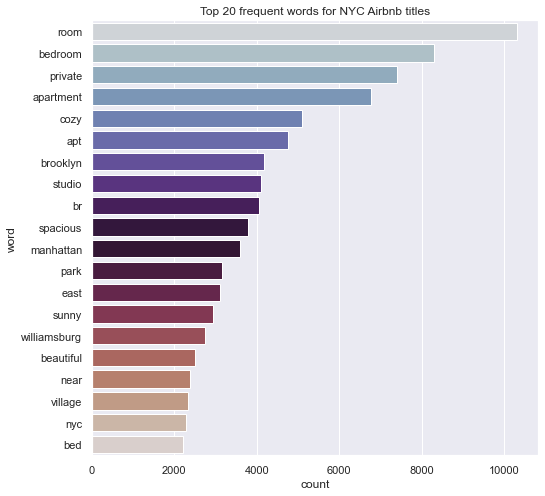

In [16]:
def plot_most_common(dict_data ,title):
    df = pd.DataFrame(dict_data)
    df.columns = ['word', 'count']
    plt.figure(figsize=(8, 8))
    sns.set(style="darkgrid")
    sns.barplot(x="count", y="word", data=df, palette='twilight')
    plt.title(title)
    plt.show()
    
plot_most_common(freq_dict.most_common(20), 'Top 20 frequent words for NYC Airbnb titles')

## <a id='freq_bigrams'></a> <font color='purple'> Most frequent bigrams to describe NYC appartments.

Most of top 20 words obtained in the previous section aren't really specific for New York. Now we'll find top bigrams, i.e. the sequences of two neighbouring words, used in Airbnb titles for NYC flats.

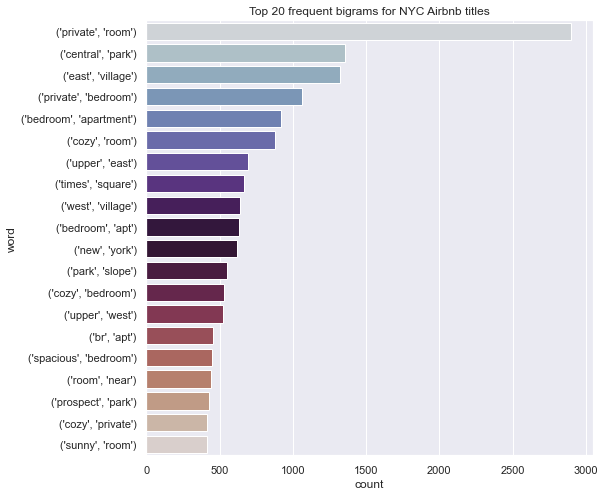

In [17]:
freq_dict_bigrams = nltk.FreqDist(nltk.bigrams(w for w in tokenized_text))
plot_most_common(freq_dict_bigrams.most_common(20), 'Top 20 frequent bigrams for NYC Airbnb titles')

Well, now the plot looks much more specific for the city. We can see such bigrams as:
* East and West Village
* Central Park
* New York
* Upper East

## <a id='freq_trigrams'></a> <font color='purple'> Most frequent trigrams to describe NYC appartments.

As long as we are here and looking at n-grams used in Airbnb titles, let's create a plot for top trigrams.
    
We find a very interesting trigram indeed - hell's kitchen - the name of a popular NYC area.

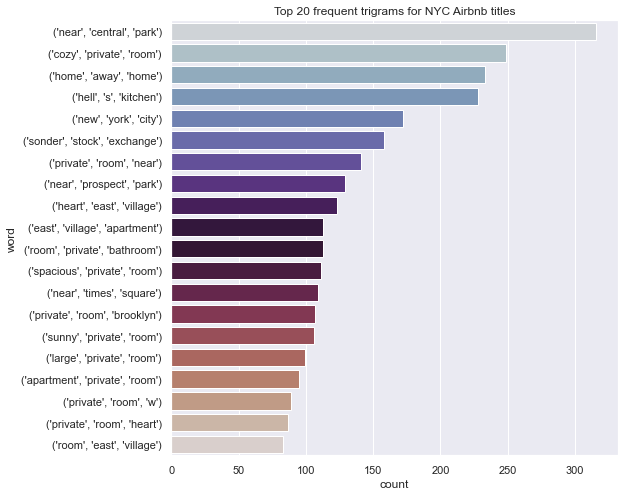

In [18]:
freq_dict_trigrams = nltk.FreqDist(nltk.trigrams(w for w in tokenized_text))
plot_most_common(freq_dict_trigrams.most_common(20), 'Top 20 frequent trigrams for NYC Airbnb titles')

## <a id='price'></a> <font color='green'> But what about the price?

Can we predict, at least approximately, how much a place will cost us just by looking at its Airbnb title?

Well, let's find out.

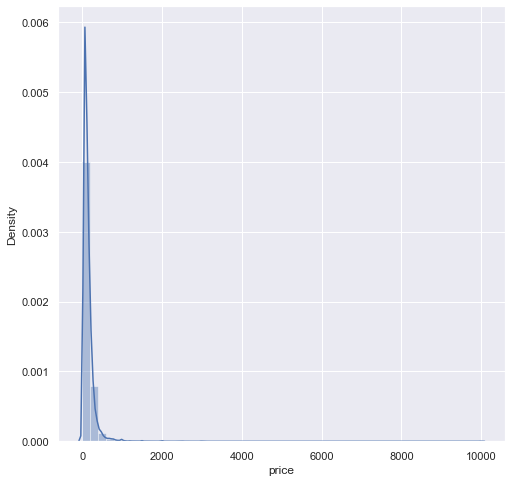

In [22]:
# First, we are going to take a look at the price distribution
plt.figure(figsize=(8, 8))
sns.distplot(data['price'])
plt.show()

In [23]:
data['price'].describe()

count    48895.000000
mean       152.720687
std        240.154170
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max      10000.000000
Name: price, dtype: float64

Most apparntments can be rented with approximately \$200. However, the right tail is quite long meaning there are places with much higher prices.

## <a id='top_costly_words'></a> <font color='scarlett'> Most frequent wordings for expensive places

Let's explore the titles of the appartments that cost more than 1k for a night.

In [24]:
costly = data[data['price']>1000]
costly.shape

(239, 18)

In [25]:
# first, we need to concatenate all descriptions in one string
costly_text = ""
for i in costly['final_name']:
    costly_text += " " + i
    
# next, we tokenize it into separate words
tokenized_costly_text = nltk.tokenize.word_tokenize(costly_text)

# finally, create a frequency dictionary with the help of nltk
freq_dict_costly = nltk.FreqDist(w for w in tokenized_costly_text)

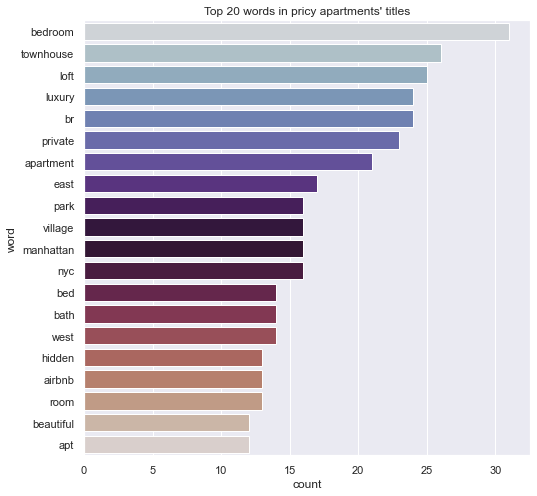

In [26]:
plot_most_common(freq_dict_costly.most_common(20), "Top 20 words in pricy apartments' titles")

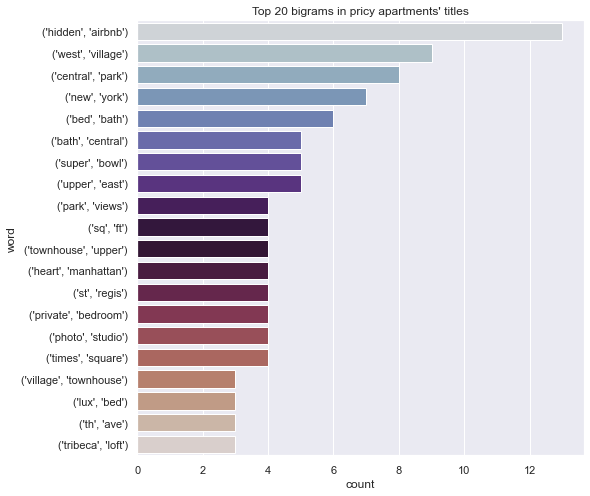

In [27]:
freq_dict_bigrams_costly = nltk.FreqDist(nltk.bigrams(w for w in tokenized_costly_text))
plot_most_common(freq_dict_bigrams_costly.most_common(20), "Top 20 bigrams in pricy apartments' titles")

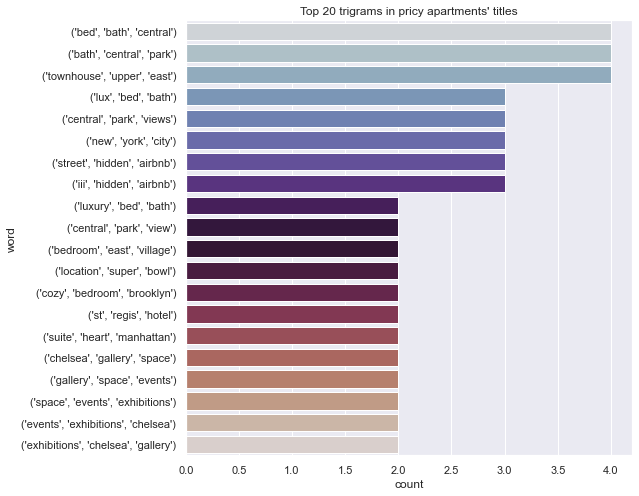

In [28]:
freq_dict_trigrams_costly = nltk.FreqDist(nltk.trigrams(w for w in tokenized_costly_text))
plot_most_common(freq_dict_trigrams_costly.most_common(20), "Top 20 trigrams in pricy apartments' titles")

By looking at the plots above, it's easy to identify some kind of pattern. We encounter some terms that weren't present in the list of frequently used words when we were looking at all the data.

Titles for appartments with high end prices uses such words as:
* lux, luxury
* Manhattan
* Townhouse
* Chelsea Gallery
* Super Bowl
* park views

Seems right to me. You *do* expect an appartment with a park view or near Chelsea Gallery to be a bit more expensive than a median price tag. The same for the term "luxury".

## <a id='model'></a> <font color='navy'> ML model

Now let's create a baseline ML model that will try to answer the question "Is the price of an Airbnb place in New York higher than 500 a night?" by utilizing only the title describing an appartment.

In [35]:
def new_target(line):
    if line > 500:
        return 1
    else:
        return 0
        
data['target'] = data['price'].apply(new_target)
data['target'].value_counts()

0    47851
1     1044
Name: target, dtype: int64

In [36]:
train, test = train_test_split(data, test_size=0.2, random_state=315, stratify=data['target'])

X_train, y_train = train['final_name'], train['target']
X_test, y_test = test['final_name'], test['target']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((39116,), (39116,), (9779,), (9779,))

In [37]:
vect = TfidfVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

Since the classes are not balanced (there are much more objects of class 0), we'll use resampling.

More details on dealing with imabalanced data can be found in [this notebook](https://www.kaggle.com/amidala/handling-imbalanced-data-with-resampling)


In [38]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=1)

X_train_ros, y_train_ros = ros.fit_sample(X_train, y_train)
np.bincount(y_train_ros)

array([38281, 38281], dtype=int64)

In [39]:
lr = LGBMClassifier(random_state=315)
lr.fit(X_train_ros, y_train_ros)
preds = lr.predict(X_test)

In [40]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      9570
           1       0.10      0.64      0.17       209

    accuracy                           0.86      9779
   macro avg       0.54      0.75      0.55      9779
weighted avg       0.97      0.86      0.91      9779



In [41]:
def draw_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(cm_norm)
    plt.figure(figsize = (6,4))
    sns.heatmap(df_cm, annot=True, cmap="Blues")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    print("Accuracy: {0:.3f}".format(accuracy_score(y_test, y_pred)))
    print("Recall: {0:.3f}".format(recall_score(y_test, y_pred)))
    plt.show()

Accuracy: 0.864
Recall: 0.636


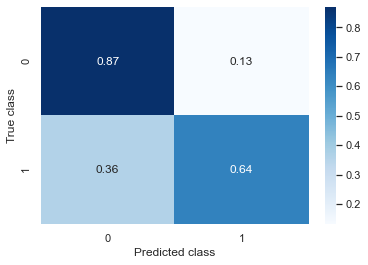

In [42]:
draw_cm(y_test, preds)

Alright, the scores aren't perfect but taking into account that the predicting model is built solely on textual descriptions of an appatment, it seems like the words in Airbnb titles actually **do** matter!


## <a id='interpret'></a> <font color='purple'> Interpreting ML predictions

Let's create human-friendly interpretations for our prediction using [LIME](https://github.com/marcotcr/lime).

More details on how to interpret ML models' predictions is in [this kernel](https://www.kaggle.com/amidala/explain-your-ml-model-no-more-black-boxes)

In [43]:
# create a pipeline and a LIME's explainer object
c = make_pipeline(vect, lr)
class_names=['cheaper', 'expensive']
explainer = LimeTextExplainer(class_names=class_names)

# use them to explain an individual prediction

ind = 48050
exp = explainer.explain_instance(test.loc[ind]['final_name'], c.predict_proba, labels=[1])
exp.show_in_notebook(text=True)

ind_pred = c.predict_proba([test.loc[ind]['final_name']])

print("True class: {}".format(class_names[test.loc[ind]['target']]))
print("Predicted class: {}".format(class_names[np.argmax(ind_pred)]))

True class: expensive
Predicted class: expensive


In [44]:
ind = 19427
exp = explainer.explain_instance(test.loc[ind]['final_name'], c.predict_proba, labels=[1])
exp.show_in_notebook(text=True)

ind_pred = c.predict_proba([test.loc[ind]['final_name']])

print("True class: {}".format(class_names[test.loc[ind]['target']]))
print("Predicted class: {}".format(class_names[np.argmax(ind_pred)]))

True class: expensive
Predicted class: expensive


The interpretation shows us that such terms as `bluebird`, `luxury`, `riverview` do appear in the titles of more expensive places. The word `group` is also frequently encountered in descriptions of a high price apartments as this usually indicates that the place is large and may be a better suit for several people.

## <a id='wrapping_up'></a> <font color='green'> Wrapping up 

In this notebook we have identified interesting patterns. For instance:
* It's possible to guess the price range of an Airbnb apartment by simply looking at its title.
* More expensive places use such words as `luxury`, `elegant`, `views`, `groups`, etc.
* Flats which titles indicate the vicinity of city attractions also tend to cost more.
    
Looks like it's important what to write in the title of your Airbnb place after all!
    
Hope you find this quick analysis helpful and funny. If so, upvote :)